## Librerias

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from sklearn.metrics import *
%matplotlib inline

Using TensorFlow backend.


In [2]:
import tensorflow

In [3]:
import keras

In [4]:
data = pd.read_csv('../data/data.csv')
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00000.au,0.349943,0.130225,1784.420446,2002.650192,3806.485316,0.083066,-113.596742,121.557302,-19.158825,...,8.810668,-3.667367,5.751690,-5.162761,0.750947,-1.691937,-0.409954,-2.300208,1.219928,blues
1,blues.00001.au,0.340983,0.095918,1529.835316,2038.617579,3548.820207,0.056044,-207.556796,124.006717,8.930562,...,5.376802,-2.239119,4.216963,-6.012273,0.936109,-0.716537,0.293875,-0.287431,0.531573,blues
2,blues.00002.au,0.363603,0.175573,1552.481958,1747.165985,3040.514948,0.076301,-90.754394,140.459907,-29.109965,...,5.789265,-8.905224,-1.083720,-9.218359,2.455805,-7.726901,-1.815724,-3.433434,-2.226821,blues
3,blues.00003.au,0.404779,0.141191,1070.119953,1596.333948,2185.028454,0.033309,-199.431144,150.099218,5.647594,...,6.087676,-2.476420,-1.073890,-2.874777,0.780976,-3.316932,0.637981,-0.619690,-3.408233,blues
4,blues.00004.au,0.308590,0.091563,1835.494603,1748.362448,3580.945013,0.101500,-160.266031,126.198800,-35.605448,...,-2.806385,-6.934122,-7.558619,-9.173552,-4.512166,-5.453538,-0.924162,-4.409333,-11.703781,blues


In [5]:
data.shape

(1000, 28)

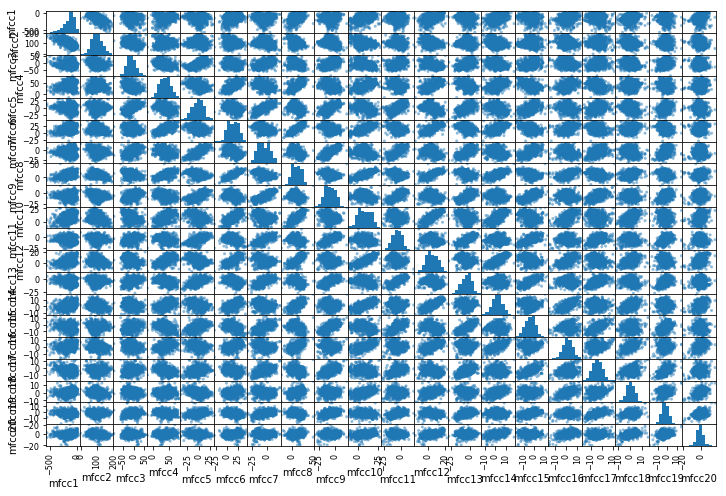

In [6]:
attributes = ['mfcc%d'%i for i in range(1,21)]
pd.plotting.scatter_matrix(data[attributes], figsize=(12,8));


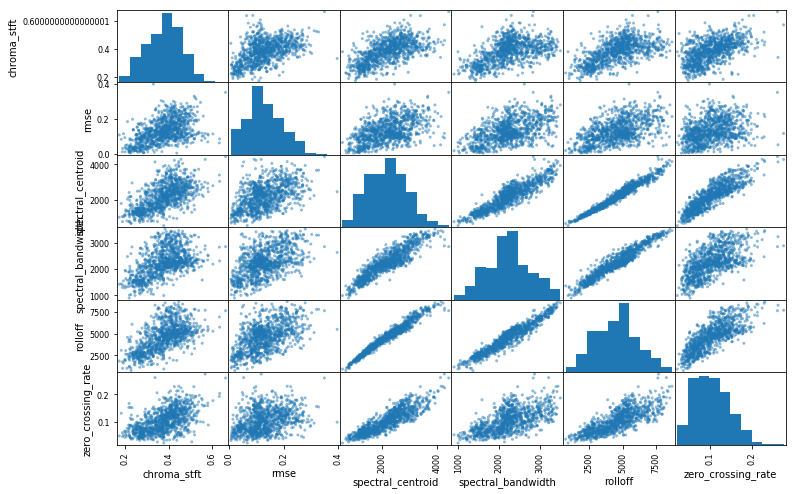

In [7]:
attributes2 = ['chroma_stft','rmse','spectral_centroid', 'spectral_bandwidth', 'rolloff','zero_crossing_rate']
pd.plotting.scatter_matrix(data[attributes2], figsize=(12,8));

## PREPROCESSING



In [8]:
from sklearn import preprocessing


In [9]:
labels = data.iloc[:, -1]
encoder = preprocessing.LabelEncoder()


In [10]:
y = encoder.fit_transform(labels)#se obtienen los labels 
print(y.shape,np.unique(y))

(1000,) [0 1 2 3 4 5 6 7 8 9]


In [11]:
# Dropping de columnas inncesarias
data = data.drop(['filename'],axis=1)

In [12]:
scaler = preprocessing.StandardScaler()#Se estandarizan las caracteristicas Z=(x-u)/s
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [13]:
#guardamos los valores de las medias y desviaciones estándar
np.save("medias", scaler.mean_)
np.save("desvest", scaler.scale_)

In [14]:
data.shape

(1000, 27)

In [15]:
print(X.shape,y.shape)

(1000, 26) (1000,)


In [16]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [17]:
def tpr(est,X,y):
    p = est.predict(X)
    return np.mean (p[y==1] == y[y==1])

def tnr(est,X,y):
    p = est.predict(X)
    return np.mean(p[y==0] == y[y==0])

## RANDOM FOREST y NAIVE GAUSSIAN


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB    
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import *

import seaborn as sn

rf = RandomForestClassifier(n_estimators=200)
g = GaussianNB() 
#Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=.2)
#rf.fit(Xtr,ytr)
#g.fit(Xtr,ytr)
rf.fit(X_train,y_train)
g.fit(X_train,y_train)
print("Random Forest Accuracy :",rf.score(X_test,y_test))
print("Naive Bayes Accuracy :",g.score(X_test,y_test))
print("Shape :",X.shape)
X2 = PCA(n_components=20).fit_transform(X)
print ("shape after PCA:", X2.shape)
srf = cross_val_score(GaussianNB(), X2, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print ("RF accuracy %.3f (+/- %.5f)"%(np.mean(srf), np.std(srf)))
s = cross_val_score(GaussianNB(), X2, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print ("GNB accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

predictions=rf.predict(X_test)
rf_model_cm = confusion_matrix(y_test, predictions)
rf_model_df_cm = pd.DataFrame(rf_model_cm)  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(rf_model_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show()

Random Forest Accuracy : 0.64
Naive Bayes Accuracy : 0.44
Shape : (1000, 26)
shape after PCA: (1000, 20)
RF accuracy 0.574 (+/- 0.05407)
GNB accuracy 0.573 (+/- 0.02934)


NameError: name 'Xts' is not defined

## Naive Gaussian Bayes another approach

In [ ]:
from sklearn.naive_bayes import GaussianNB   
estGNB = GaussianNB()
s1GNB = cross_val_score(estGNB, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s1GNB), np.std(s1GNB)))
s2GNB = cross_val_score(estGNB, X, y, cv=KFold(10, shuffle=True), scoring=tpr)
print("tpr      %.3f (+/- %.5f)"%(np.mean(s2GNB), np.std(s2GNB)))
s3GNB = cross_val_score(estGNB, X, y, cv=KFold(10, shuffle=True), scoring=tnr)
print("tnr      %.3f (+/- %.5f)"%(np.mean(s3GNB), np.std(s3GNB)))

## Random Forest Classifier another approach

In [ ]:
from sklearn.ensemble import RandomForestClassifier
estRFC = RandomForestClassifier(n_estimators = 20)
s1RFC = cross_val_score(estRFC, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s1RFC), np.std(s1RFC)))
s2RFC = cross_val_score(estRFC, X, y, cv=KFold(10, shuffle=True), scoring=tpr)
print("tpr      %.3f (+/- %.5f)"%(np.mean(s2RFC), np.std(s2RFC)))
s3RFC = cross_val_score(estRFC, X, y, cv=KFold(10, shuffle=True), scoring=tnr)
print("tnr      %.3f (+/- %.5f)"%(np.mean(s3RFC), np.std(s3RFC)))

## Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
estDTC = DecisionTreeClassifier()
s1DTC = cross_val_score(estDTC, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s1DTC), np.std(s1DTC)))
s2DTC = cross_val_score(estDTC, X, y, cv=KFold(10, shuffle=True), scoring=tpr)
print("tpr      %.3f (+/- %.5f)"%(np.mean(s2DTC), np.std(s2DTC)))
s3DTC = cross_val_score(estDTC, X, y, cv=KFold(10, shuffle=True), scoring=tnr)
print("tnr      %.3f (+/- %.5f)"%(np.mean(s3DTC), np.std(s3DTC)))

## Support Vector Machine

In [ ]:
from sklearn.svm import SVC
estSVC = SVC(gamma='auto')
s1SVC = cross_val_score(estSVC, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s1SVC), np.std(s1SVC)))
s2SVC = cross_val_score(estSVC, X, y, cv=KFold(10, shuffle=True), scoring=tpr)
print("tpr      %.3f (+/- %.5f)"%(np.mean(s2SVC), np.std(s2SVC)))
s3SVC = cross_val_score(estSVC, X, y, cv=KFold(10, shuffle=True), scoring=tnr)
print("tnr      %.3f (+/- %.5f)"%(np.mean(s3SVC), np.std(s3SVC)))

## USING KERAS

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(10, activation='softmax'))


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=20)

In [ ]:
test_loss, test_acc = model.evaluate(X_test,y_test)

In [ ]:
print('test_acc: ',test_acc)
print('test_loss: ',test_loss)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
model_pred = model.predict(X_test)  

values_predicted = np.argmax(model_pred,axis=1)
model_cm = confusion_matrix(y_test, values_predicted)
model_df_cm = pd.DataFrame(model_cm)  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(model_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  


In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    # serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
"""

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

"""

In [ ]:
"""

#compiling the loaded model
loaded_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
"""

In [ ]:
"""

#evaluating the loaded model
test_loss, test_acc = loaded_model.evaluate(X_test,y_test)

"""

In [ ]:
"""

print('test_acc: ',test_acc)

"""

# Comparación de diferentes clasificadores
##### Se lista la precisión obtenida por los diferentes clasificadores con los cuáles se realizo la clasificación, por medio del accuracy score.

In [ ]:
from IPython.display import display, HTML
table = [["Naive Gaussian Bayes", np.mean(s1GNB)],
         ["Decision Tree Classifier",np.mean(s1DTC)],
         ["Random Forest Classifier",np.mean(s1RFC)],
         ["Support Vector Machine",np.mean(s1SVC)],
         ["Keras Sequential Model",test_acc]]
compDF = pd.DataFrame(table, columns=["Clasificador", "Accuracy"]);



In [ ]:
# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '40px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '30px'),
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]


(compDF.style
    .format({'total_amt_usd_pct_diff': "{:.2%}"})
    .set_table_styles(styles)
    .hide_index())

